In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSBBS'
m='SNWD'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1539.8|    38.6|-119.4833|       SNWD|USC00048969|    20|[00 00 00 00 00 0...|1954.0|SSSBSBBS|
|   1410.9| 38.8667|-117.9167|       SNWD|USC00262948|    36|[00 7E 00 7E 00 7...|2012.0|SSSBSBBS|
|    723.0| 38.3833|-120.5667|       SNWD|USC00049583|     1|[00 00 60 56 C0 5...|1950.0|SSSBSBBS|
|    723.0| 38.3833|-120.5667|       SNWD|USC00049583|     1|[00 00 00 00 00 0...|1951.0|SSSBSBBS|
|    723.0| 38.3833|-120.5667|       SNWD|USC00049583|     4|[00 00 00 00 00 0...|1952.0|SSSBSBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

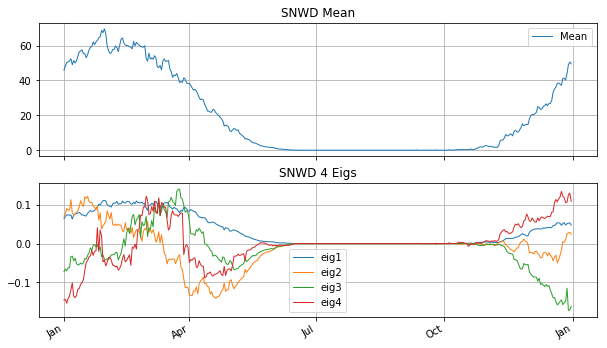

In [7]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=4 # for parquet file. 3 for analysis.

EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' %d Eigs'%k,labels=['eig'+str(i+1) for i in range(k)])
#savefig('my_figures/SNWD_mean_%deigs.png'%k)

In [8]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

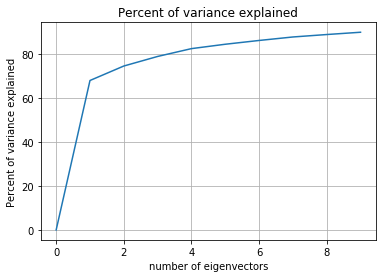

In [9]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [10]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [11]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1464
after filter 330


In [12]:
# Sort entries by increasing values of res_3. I have updated the name from 0 to 2 to 1 to 3 to be consistent with the writing.
df4=df3.sort(df3.res_3,ascending=True)

In [13]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10), coeff=2):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            _title = '%s %d c%d=%4.2f, r%d=%3.2f'%(row['station'], row['year'], coeff, row['coeff_%d'%coeff], coeff, row['res_%d'%coeff])
            if row_n == 1 or column_n ==1:
                index = max(i, j)
                plot_decomp(row,Mean,v,fig=fig,ax=axes[index], Title = _title, interactive=False)
            else:
#                print i,j,_title,axes[i,j]
                plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j], Title = _title, interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [21]:
# setup figure configurations.
def plotCoeff(df, coeff_index=2, column_n=4, row_n=3):
    n_samples = column_n * row_n
    cellsize = 5
    df_new_asc = df.sort(df['coeff_%d'%coeff_index])
    asc_rows=df_new_asc.take(n_samples)
    df_new_dec = df.sort(df['coeff_%d'%coeff_index], ascending=False)
    des_rows=df_new_dec.take(n_samples)
    print "most negative"
    df_new_asc.select('coeff_%d'%coeff_index,'res_%d'%coeff_index).show(4)
    print "most positive"

    df_new_dec.select('coeff_%d'%coeff_index,'res_%d'%coeff_index).show(4)
    plot_recon_grid(asc_rows, column_n, row_n, (column_n*cellsize, row_n*cellsize), coeff_index)
    savefig('my_figures/SNWD_coeff%d_neg%d.png'%(coeff_index, n_samples))
    plot_recon_grid(des_rows, column_n, row_n, (column_n*cellsize, row_n*cellsize), coeff_index)
    savefig('my_figures/SNWD_coeff%d_pos%d.png'%(coeff_index, n_samples))
    
    # return a representitive to plot interactive plots.
    rep= des_rows[0]
    return rep

def plotInteractive(row):
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    eigen_decomp=Eigen_decomp(None,target,Mean,v)
    total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
    res=residuals[1]
    print 'residual normalized norm  after mean:',res[0]
    print 'residual normalized norm  after mean + top eigs:',res[1:]

    plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
    display(plotter.get_Interactive())

most negative
+-------------------+------------------+
|            coeff_1|             res_1|
+-------------------+------------------+
| -411.7033771565134|0.8489456664036683|
|-398.33039447779316|0.8953330624872924|
| -394.5106782467064|0.9686341925625358|
|  -377.254783258707|0.8499916340212441|
+-------------------+------------------+
only showing top 4 rows

most positive
+------------------+-------------------+
|           coeff_1|              res_1|
+------------------+-------------------+
|13076.705011155134|0.10083434297470495|
|12934.805238149642|0.15449953351754048|
|12806.447505090291|0.07424592157516338|
|12228.827571180398|0.18886211303327827|
+------------------+-------------------+
only showing top 4 rows



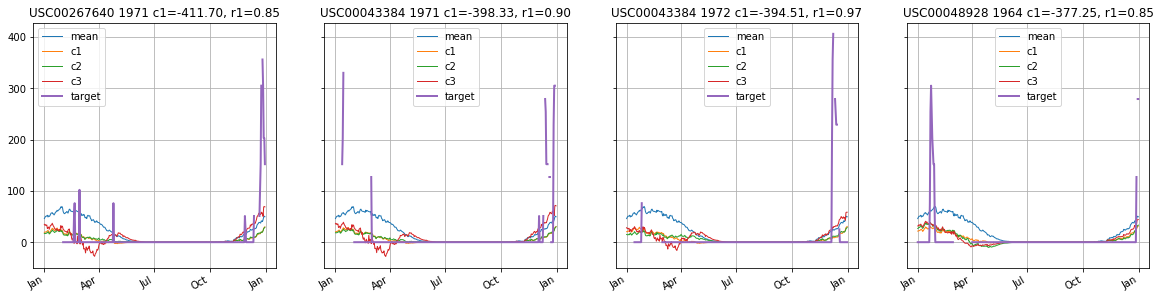

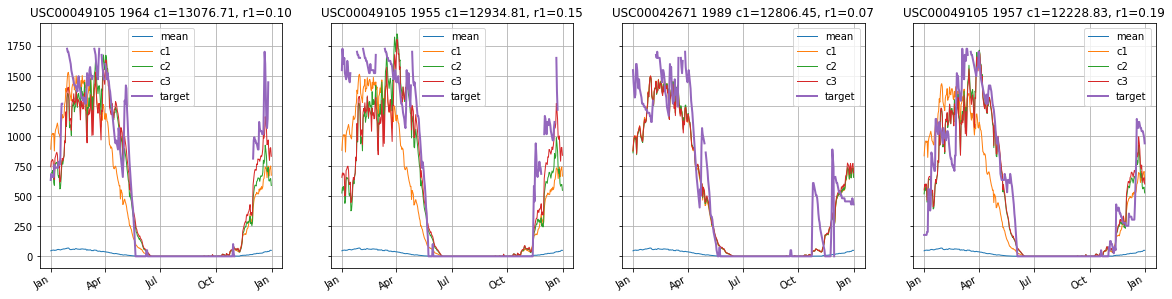

In [22]:
rep = plotCoeff(df3, coeff_index=1, column_n=4, row_n=1)

residual normalized norm  after mean: 0.937003393323
residual normalized norm  after mean + top eigs: [ 0.10083434  0.05671853  0.04592818]


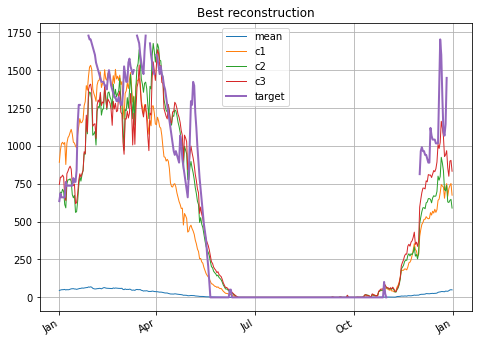

In [24]:
plotInteractive(rep)

most negative
+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
|-5238.305667275657|0.14960291237972903|
|-5018.069523170187|0.12108374913481731|
|-4806.644028305771|0.07909749220095072|
|-4473.351305608822|0.07431085097109054|
+------------------+-------------------+
only showing top 4 rows

most positive
+------------------+-------------------+
|           coeff_2|              res_2|
+------------------+-------------------+
| 4561.016116622655|0.05316628297850689|
| 3604.182341654653|0.13791852384490938|
|3469.5797756341603|0.03518361990692434|
|3378.9860511386005|0.09053591125188944|
+------------------+-------------------+
only showing top 4 rows



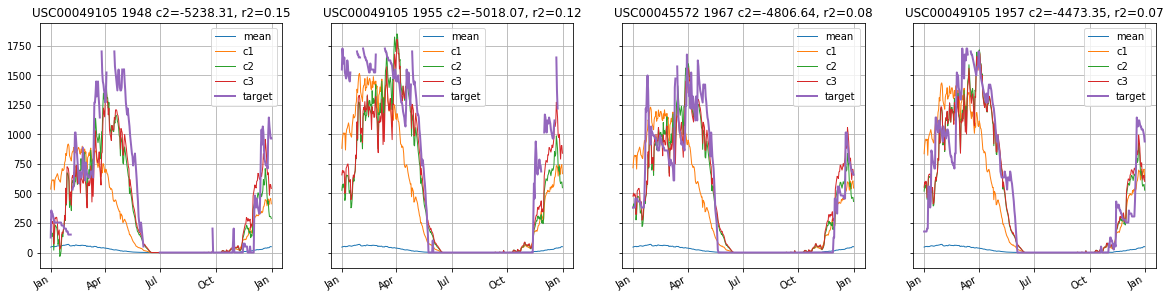

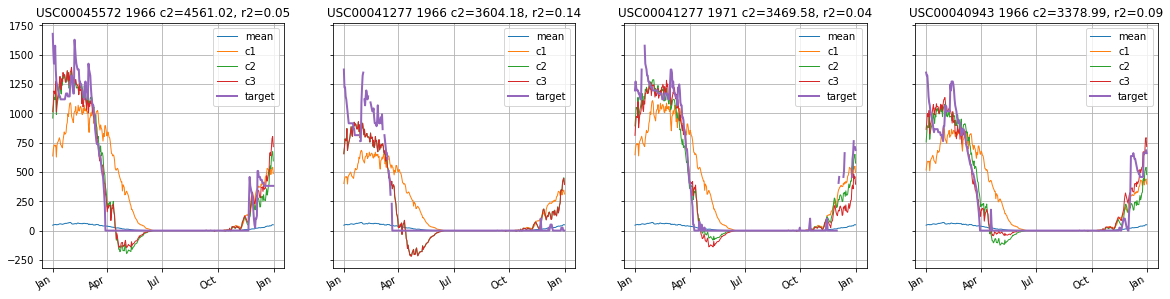

In [25]:
rep = plotCoeff(df3, coeff_index=2, column_n=4, row_n=1)

residual normalized norm  after mean: 0.906513765458
residual normalized norm  after mean + top eigs: [ 0.24247131  0.05316628  0.04804022]


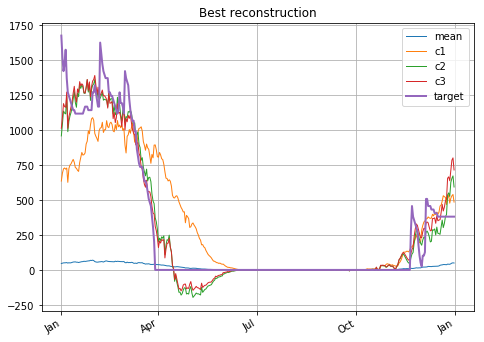

In [26]:
plotInteractive(rep)

most negative
+-------------------+-------------------+
|            coeff_3|              res_3|
+-------------------+-------------------+
| -4372.891499530633|0.14581233055539813|
| -3562.998199088166|0.25045381268410266|
|-3180.7172899373963| 0.3540299317968474|
| -3079.593986451281| 0.5122223640112278|
+-------------------+-------------------+
only showing top 4 rows

most positive
+-----------------+--------------------+
|          coeff_3|               res_3|
+-----------------+--------------------+
|4418.212987439285| 0.12409348121950027|
|4330.184297308267| 0.05448009854297874|
|3975.668171604313| 0.07306212666108897|
|3572.687629370952|0.056796420722464436|
+-----------------+--------------------+
only showing top 4 rows



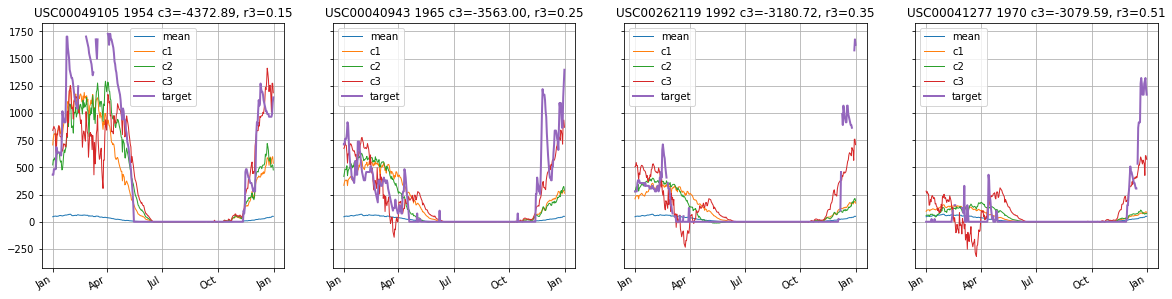

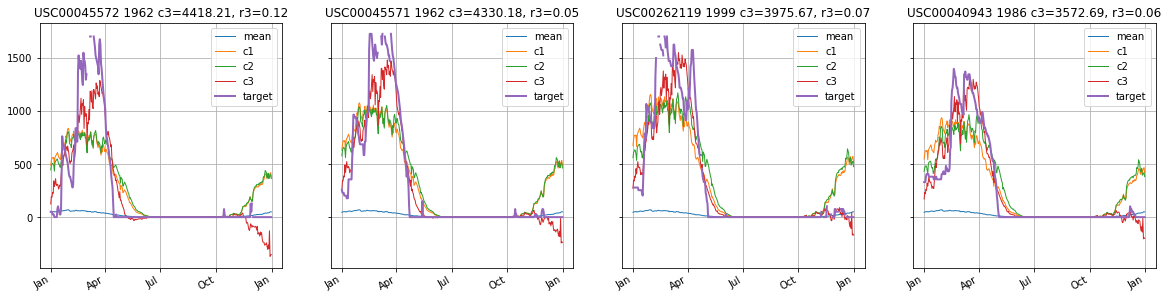

In [27]:
rep = plotCoeff(df3, coeff_index=3, column_n=4, row_n=1)

residual normalized norm  after mean: 0.917903265116
residual normalized norm  after mean + top eigs: [ 0.39466063  0.39224905  0.12409348]


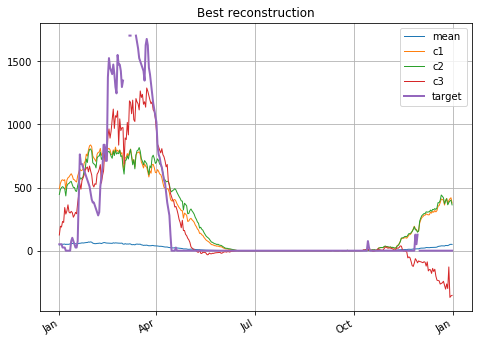

In [28]:
plotInteractive(rep)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

residual normalized norm  after mean: 0.917903265116
residual normalized norm  after mean + top eigs: [ 0.39466063  0.39224905  0.12409348]


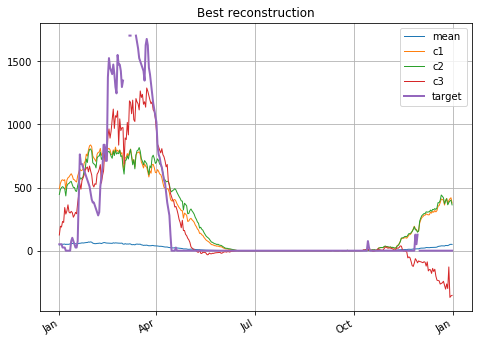

In [30]:
df5 = df3.filter(df3.res_3<0.4).sort(df3.coeff_3, ascending=False)
rows = df5.take(12)
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [31]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    # ascending order.
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(P,vals)
    title('cumulative distribution of '+feat)
    xlabel('number of instances in percentage')
    ylabel(feat)
    grid()

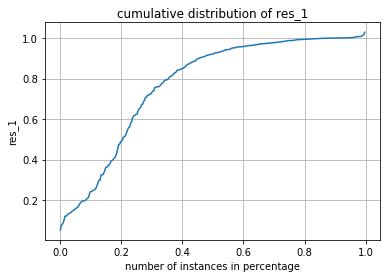

In [32]:
plot_CDF('res_1')

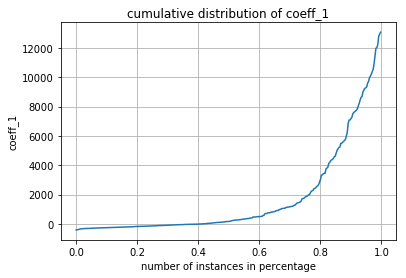

In [33]:
plot_CDF('coeff_1')

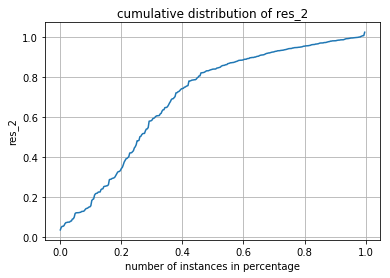

In [34]:
plot_CDF('res_2')

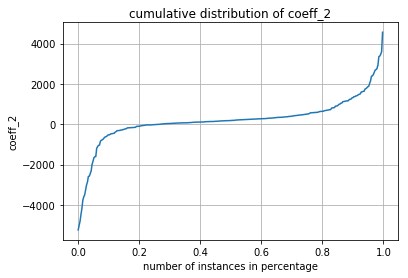

In [35]:
plot_CDF('coeff_2')

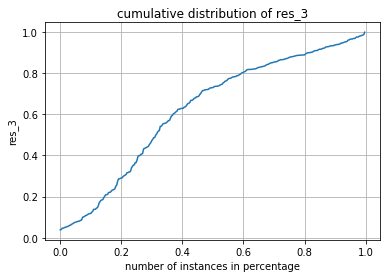

In [36]:
plot_CDF('res_3')

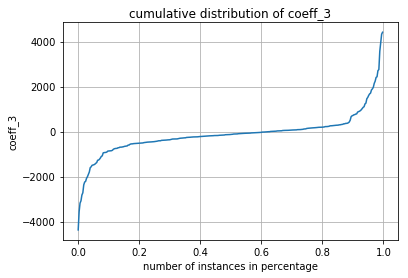

In [37]:
plot_CDF('coeff_3')

In [13]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [14]:
!du -sh $data_dir/*.parquet

4.7M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
3.8M	../../Data/Weather/US_Weather_SSSBSBBS.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB.parquet
2.4M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.2M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
512K	../../Data/Weather/decon_SSSBSBBS_PRCP.parquet
192K	../../Data/Weather/decon_SSSBSBBS_SNOW.parquet
108K	../../Data/Weather/decon_SSSBSBBS_SNWD.parquet
724K	../../Data/Weather/decon_SSSBSBBS_TOBS.parquet
